# 情感分类（Sentiment Analysis）

## 1. 实验前导

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torchtext.vocab import Vectors
from torchtext import data
from torchtext import datasets
# from torchtext.data import Field
import random
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## 2. 准备数据

#### （1）首先准备训练数据、验证数据和测试数据

- 使用torchtext自带的IMDB数据集进行情感分析：检测一段文字的情感是正面的还是负面的
- TorchText中的一个重要概念是Field。Field决定了你的数据会被怎样处理。在情感分类任务中，我们所要接触到的数据又文本字符串和两种情感，'pos'和'neg'；
- 使用TEXT Field来定义如何处理电影评论，使用Label Field来处理两个情感类别；
- torchtext能够处理很多自然语言中处理到的任务（创建vocabulary，然后把数据读成Batch的格式）

In [2]:
TEXT = data.Field(tokenize="spacy",tokenizer_language='en_core_web_sm')
LABEL = data.LabelField(dtype=torch.float)

In [3]:
train_data, test_data = datasets.IMDB.splits(TEXT,LABEL)

## 自己添加代码离线存储数据

In [4]:
import pickle
# 假设 train_data 是一个 torchtext.datasets.imdb.IMDB 对象
train_data_list = [(example.text, example.label) for example in train_data]
# 保存数据
with open('train_data.pkl', 'wb') as f:
    pickle.dump(train_data_list, f)

In [5]:
#保存test
test_data_list = [(example.text, example.label) for example in test_data]
# 保存数据
with open('test_data.pkl', 'wb') as f:
    pickle.dump(test_data_list, f)

In [6]:
# 读取数据
with open('train_data.pkl', 'rb') as f:
    train_data_list = pickle.load(f)
print(train_data_list[0])

(['Zentropa', 'has', 'much', 'in', 'common', 'with', 'The', 'Third', 'Man', ',', 'another', 'noir', '-', 'like', 'film', 'set', 'among', 'the', 'rubble', 'of', 'postwar', 'Europe', '.', 'Like', 'TTM', ',', 'there', 'is', 'much', 'inventive', 'camera', 'work', '.', 'There', 'is', 'an', 'innocent', 'American', 'who', 'gets', 'emotionally', 'involved', 'with', 'a', 'woman', 'he', 'does', "n't", 'really', 'understand', ',', 'and', 'whose', 'naivety', 'is', 'all', 'the', 'more', 'striking', 'in', 'contrast', 'with', 'the', 'natives.<br', '/><br', '/>But', 'I', "'d", 'have', 'to', 'say', 'that', 'The', 'Third', 'Man', 'has', 'a', 'more', 'well', '-', 'crafted', 'storyline', '.', 'Zentropa', 'is', 'a', 'bit', 'disjointed', 'in', 'this', 'respect', '.', 'Perhaps', 'this', 'is', 'intentional', ':', 'it', 'is', 'presented', 'as', 'a', 'dream', '/', 'nightmare', ',', 'and', 'making', 'it', 'too', 'coherent', 'would', 'spoil', 'the', 'effect', '.', '<', 'br', '/><br', '/>This', 'movie', 'is', 'unr

### ------------分割线，自己的代码结束。

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(vars(train_data.examples[0]))#每个example包含两个部分，第一部分为text,第二部分为label

Number of training examples: 25000
Number of testing examples: 25000
{'text': ['Zentropa', 'has', 'much', 'in', 'common', 'with', 'The', 'Third', 'Man', ',', 'another', 'noir', '-', 'like', 'film', 'set', 'among', 'the', 'rubble', 'of', 'postwar', 'Europe', '.', 'Like', 'TTM', ',', 'there', 'is', 'much', 'inventive', 'camera', 'work', '.', 'There', 'is', 'an', 'innocent', 'American', 'who', 'gets', 'emotionally', 'involved', 'with', 'a', 'woman', 'he', 'does', "n't", 'really', 'understand', ',', 'and', 'whose', 'naivety', 'is', 'all', 'the', 'more', 'striking', 'in', 'contrast', 'with', 'the', 'natives.<br', '/><br', '/>But', 'I', "'d", 'have', 'to', 'say', 'that', 'The', 'Third', 'Man', 'has', 'a', 'more', 'well', '-', 'crafted', 'storyline', '.', 'Zentropa', 'is', 'a', 'bit', 'disjointed', 'in', 'this', 'respect', '.', 'Perhaps', 'this', 'is', 'intentional', ':', 'it', 'is', 'presented', 'as', 'a', 'dream', '/', 'nightmare', ',', 'and', 'making', 'it', 'too', 'coherent', 'would', 'sp

In [8]:
# 查看数据类型
type(train_data.examples[0])

torchtext.data.example.Example

- 由于我们现在只有train/test两个分类，所以需要创建一个新的validation set，可以使用.split()创建新的分类。
- 默认的数据分割是70、30，如果我们声明split_ratio，可以改变split之间的比例，split_ratio=0.8表示80%的数据是训练集，20%是验证集

In [9]:
train_data, valid_data = train_data.split(random_state=random.seed(SEED)) #默认使用70%作为训练，30%作为验证

In [10]:
# 至此已经完成了训练数据，测试数据和验证数据的分割
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


#### （2）其次进行数据预处理：将单词和标签转换为index

In [11]:
# 从训练数据中构建词典
vectors = Vectors(name = './glove.6B.100d.txt')
TEXT.build_vocab(train_data, max_size=25000, vectors=vectors,unk_init=torch.Tensor.normal_)
#使用glove预训练的词向量,词向量在：https://nlp.stanford.edu/projects/glove/中下载
#TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)
# build_vocab的本质是把一个单词map到一个index上面

In [12]:
print(f'Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}') # 25000个高频单词+<unk>+<pad>
print(f'Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}')

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [13]:
print(TEXT.vocab.freqs.most_common(10))
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

[('the', 202342), (',', 192592), ('.', 165448), ('a', 109503), ('and', 109493), ('of', 100784), ('to', 93530), ('is', 76110), ('in', 61318), ('I', 54054)]
['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']
defaultdict(None, {'pos': 0, 'neg': 1})


#### （3）创建iterator，将数据按照batch返回

- 使用BucketIterator,BucketIterator会把长度差不多的句子放到同一个batch中，确保每个batch中不出现太多的padding

In [14]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits( 
    (train_data,valid_data,test_data),
    batch_size = BATCH_SIZE,
    device = device)

In [15]:
batch = next(iter(train_iterator))
# batch.label #代表标签
# batch.text #每一列是一个句子，以1结尾，1代表pad
# batch.text[:,0] #第一列
#print(' '.join(TEXT.vocab.itos[i] for i in batch.text[:,0]))
#[TEXT.vocab.itos[i] for i in batch.text[:,0]]

In [16]:
print(' '.join(TEXT.vocab.itos[i] for i in batch.text[:,0]))

I 'm a big fan of <unk> , having caught on only at the end of season three . I faithfully watched all the previous seasons when it was <unk> , concluding that it was one of the most well - thought out story arcs to ever hit television . Even the filler episodes were interesting . The movies , also , were well produced and as entertaining as anything to hit the <unk> /><br />Which brings us to ' River of Souls ' . Naturally , after seeing everything else , I had high expectations . Martin Sheen appears to be acting in an Ed Wood movie rather than a serious Sci - Fi story . The story itself , might have looked good in outline form , even made it to the story board . However , it suffers obviously when it came time to filling this notion out into a two hour movie . There are no special effects to keep us entertained in the total absence of a compelling story . There are places where they were obviously short of time and just improvised the dialog to fill the story out . Had this made the 

## 3. 配置网络

按照模型从简单到复杂，依次构建三种模型：

- Word Averaging模型
- RNN/LSTM模型
- CNN模型

#### （1）Word Averaging模型

- 把每个单词都通过Embedding层映射成word embedding vector,然后把所有的word vector做个平均，就是整个句子的vector表示了，接下来把这个sentence vector传入一个Linear层，做分类即可

In [17]:
class WordAVGModel(nn.Module):
    def __init__(self,vocab_size,embedding_size,output_size,pad_idx):
        super(WordAVGModel,self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size,padding_idx=pad_idx)#padding_idx会将<pad>初始化为全0
        self.linear = nn.Linear(embedding_size,output_size)
    def forward(self,text):
        embeded = self.embed(text) # [sequence_len, batch_size, embedding_size]
        #embeded = embeded.transpose(1,0) #[batch_size, sequence_len, embedding_size]
        embeded = embeded.permute(1,0,2) #[batch_size, sequence_len, embedding_size]
        pooled = F.avg_pool2d(embeded,(embeded.shape[1],1)).squeeze() # embeded.shape[1] = sequence_len
        return self.linear(pooled)

In [18]:
# 定义模型
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_SIZE = 100
OUTPUT_SIZE = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
wordmodel = WordAVGModel(vocab_size=VOCAB_SIZE,
                     embedding_size=EMBEDDING_SIZE,
                     output_size=OUTPUT_SIZE,
                     pad_idx=PAD_IDX)

In [19]:
TEXT.unk_token

'<unk>'

In [20]:
def count_parameters(model):
    # next(model.parameters()).numel()
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(wordmodel)

2500301

In [21]:
# 初始化Embedding矩阵
pretrained_embedding = TEXT.vocab.vectors
#pretrained_embedding.shape # [25002,100]
wordmodel.embed.weight.data.copy_(pretrained_embedding) #用事先训练好的embeeding来初始化
wordmodel.embed.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_SIZE)
wordmodel.embed.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_SIZE)

In [22]:
def binary_accuracy(preds,y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()#(rounded_preds == y)返回的是bool类型的结果
    acc = correct.sum()/len(correct)
    return acc

In [23]:
def train(model, iterator, optimizer, crit):
    epoch_loss, epoch_acc = 0., 0.
    total_len = 0.
    model.train()    
    for batch in iterator:
        # forward pass
        # print("batch.text.shape:",batch.text.shape)
        preds = model(batch.text).squeeze()
        # print("preds.shape:",preds.shape)
        # print("batch.label.shape:",batch.label.shape)
        loss = crit(preds,batch.label)
        acc = binary_accuracy(preds,batch.label)
        # backward pass
        optimizer.zero_grad() #梯度清零
        loss.backward() # 反向传播，计算梯度
        optimizer.step() #更新参数
        
        epoch_loss += loss.item() * len(batch.label)
        epoch_acc += acc.item() * len(batch.label)
        total_len += len(batch.label)
    return epoch_loss/total_len, epoch_acc/total_len

In [24]:
def evaluate(model, iterator, crit):
    epoch_loss, epoch_acc = 0., 0.
    total_len = 0.
    model.eval()    
    for batch in iterator:
        # forward pass
        preds = model(batch.text).squeeze()
        loss = crit(preds,batch.label)
        acc = binary_accuracy(preds,batch.label)
        
        epoch_loss += loss.item() * len(batch.label)
        epoch_acc += acc.item() * len(batch.label)
        total_len += len(batch.label)
    model.train() 
    return epoch_loss/total_len, epoch_acc/total_len

In [25]:
# 训练模型
crit = nn.BCEWithLogitsLoss()#binary cross entropy
optimizer = torch.optim.Adam(wordmodel.parameters())
wordmodel = wordmodel.to(device)
N_EPOCHES = 20
best_valid_acc = 0.
for epoch in range(N_EPOCHES):
    train_loss, train_acc = train(wordmodel,train_iterator,optimizer,crit)
    valid_loss, valid_acc = evaluate(wordmodel,valid_iterator,crit)
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(wordmodel.state_dict(),"wordavg-best-model.pth")
    print("Epoch:",epoch, "Train Loss:", train_loss, "Train Acc:", train_acc)
    print("Epoch:",epoch, "Valid Loss:", valid_loss, "Valid Acc:", valid_acc)

Epoch: 0 Train Loss: 0.6863600972993034 Train Acc: 0.5822857142993382
Epoch: 0 Valid Loss: 0.6228502765019734 Valid Acc: 0.7302666666666666
Epoch: 1 Train Loss: 0.6456488602093288 Train Acc: 0.7197714286804199
Epoch: 1 Valid Loss: 0.4932324107170105 Valid Acc: 0.7682666667302449
Epoch: 2 Train Loss: 0.5722647533144269 Train Acc: 0.7908000000817436
Epoch: 2 Valid Loss: 0.42996904436747235 Valid Acc: 0.8080000000635783
Epoch: 3 Train Loss: 0.49981179449898855 Train Acc: 0.8297142857824054
Epoch: 3 Valid Loss: 0.3975183746337891 Valid Acc: 0.835066666730245
Epoch: 4 Train Loss: 0.4350914260183062 Train Acc: 0.8602857143947056
Epoch: 4 Valid Loss: 0.3858402350902557 Valid Acc: 0.8508000000635783
Epoch: 5 Train Loss: 0.3872138711180006 Train Acc: 0.8795428572246007
Epoch: 5 Valid Loss: 0.39407181444168093 Valid Acc: 0.8613333333969116
Epoch: 6 Train Loss: 0.3474335999011993 Train Acc: 0.8909714286804199
Epoch: 6 Valid Loss: 0.4040147019783656 Valid Acc: 0.8708000000317891
Epoch: 7 Train Los

In [26]:
# 测试模型
wordmodel.load_state_dict(torch.load("wordavg-best-model.pth"))
test_loss1, test_acc1 = evaluate(wordmodel,test_iterator,crit)
print("wordmodel模型在测试集上表现为:")
print("测试损失Test Loss:", test_loss1, "测试精度Test Acc:", test_acc1)


wordmodel模型在测试集上表现为:
测试损失Test Loss: 0.6876286530971527 测试精度Test Acc: 0.884640000038147


In [27]:
# 利用模型来预测Sentiment
import spacy
nlp = spacy.load("en_core_web_sm")
def predict_sentiment(sentence,model):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device) # seq_len
    tensor = tensor.unsqueeze(1) # seq_len * batch_size
    pred = torch.sigmoid(model(tensor))
    return pred.item()
#函数作用
#nlp.tokenizer(sentence)：将句子分词
#[tok.text for tok in nlp.tokenizer(sentence)]：将分词后的结果转换为list
#[TEXT.vocab.stoi[t] for t in tokenized]：将list中的每个单词转换为index
#torch.LongTensor(indexed).to(device)：将index转换为tensor
#tensor = tensor.unsqueeze(1)：将tensor的维度从[seq_len]转换为[seq_len,1]
#pred = torch.sigmoid(model(tensor))：将tensor输入到模型中，得到预测结果
#pred.item()：将tensor转换为python中的数字
#上述函数的预测结果如何理解
#pred.item()的值越大，表示句子的情感越正面；pred.item()的值越小，表示句子的情感越负面

In [28]:
predict_sentiment("This film is good",wordmodel)#horrible,terrific,terrible

4.5682803492464694e-33

# 第二个模型：RNN模型

基于循环神经网络（RNN）的文本分类模型。下面是对该模型的分析：

1、初始化函数（__init__）：
 - vocab_size：词汇表大小，表示文本数据中不同词汇的数量。
 - embedding_size：嵌入层的维度，用于将文本数据转换为稠密向量表示。
 - output_size：模型输出的维度，表示分类任务的类别数量。
 - pad_idx：填充标记的索引，在文本序列中用于标记填充部分。
 - hidden_size：RNN隐藏层的维度。
 - n_layers：RNN的层数。
 - bidirectional：是否使用双向RNN。
 - dropout：dropout比例，用于在训练过程中随机丢弃一部分神经元，以防止过拟合。


2、前向传播函数（forward）：
 - embed：将输入的文本序列进行嵌入操作，将每个词汇映射为一个稠密向量。
 - rnn：将嵌入后的文本序列输入到LSTM中，得到输出序列、最后一个时间步的隐藏状态和细胞状态。
 - linear：将最后一个时间步的隐藏状态通过线性层进行分类预测，并返回预测结果。
 - dropout：对嵌入后的文本序列进行dropout操作。
模型的输入输出维度：
输入：文本序列的维度为[sequence_len, batch_size]，其中sequence_len表示序列的长度，batch_size表示每批次输入的样本数量。
输出：模型的输出维度为[batch_size, output_size]，其中output_size表示分类任务的类别数量。
该模型使用了LSTM作为RNN的基本单元，通过双向RNN和线性层将最后一个时间步的隐藏状态转化为分类预测结果。在前向传播过程中，使用了dropout操作来减少过拟合的风险。

In [29]:

class RNNModel(nn.Module):
    def __init__(self,vocab_size,embedding_size,output_size,pad_idx,hidden_size,n_layers,bidirectional,dropout):
        super(RNNModel,self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size,padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_size,hidden_size,num_layers=n_layers,bidirectional=bidirectional,dropout=dropout)
        self.linear = nn.Linear(hidden_size*2,output_size)
        self.dropout = nn.Dropout(dropout)
    def forward(self,text):
        embeded = self.dropout(self.embed(text)) # [sequence_len, batch_size, embedding_size]
        output, (hidden, cell) = self.rnn(embeded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1))
        return self.linear(hidden)
#模型的输入输出维度
#输入：[sequence_len, batch_size]
#输出：[batch_size, output_size]


In [30]:
# 定义模型
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_SIZE = 100
OUTPUT_SIZE = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
HIDDEN_SIZE = 100
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
rnnmodel = RNNModel(vocab_size=VOCAB_SIZE,
                     embedding_size=EMBEDDING_SIZE,
                     output_size=OUTPUT_SIZE,
                     pad_idx=PAD_IDX,
                     hidden_size=HIDDEN_SIZE,
                     n_layers=N_LAYERS,
                     bidirectional=BIDIRECTIONAL,
                     dropout=DROPOUT)

In [31]:
# 初始化Embedding矩阵
pretrained_embedding = TEXT.vocab.vectors
#pretrained_embedding.shape # [25002,100]
rnnmodel.embed.weight.data.copy_(pretrained_embedding) #用事先训练好的embeeding来初始化
rnnmodel.embed.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_SIZE)
rnnmodel.embed.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_SIZE)

In [32]:
# 训练模型
crit = nn.BCEWithLogitsLoss()#binary cross entropy
optimizer = torch.optim.Adam(rnnmodel.parameters())
rnnmodel = rnnmodel.to(device)
N_EPOCHES = 20
best_valid_acc = 0.
for epoch in range(N_EPOCHES):
    train_loss, train_acc = train(rnnmodel,train_iterator,optimizer,crit)
    valid_loss, valid_acc = evaluate(rnnmodel,valid_iterator,crit)
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(rnnmodel.state_dict(),"rnn-best-model.pth")
    print("Epoch:",epoch, "Train Loss:", train_loss, "Train Acc:", train_acc)
    print("Epoch:",epoch, "Valid Loss:", valid_loss, "Valid Acc:", valid_acc)

Epoch: 0 Train Loss: 0.6851194984844753 Train Acc: 0.5577714286259242
Epoch: 0 Valid Loss: 0.6590333771387736 Valid Acc: 0.6042666666666666
Epoch: 1 Train Loss: 0.6126890558310918 Train Acc: 0.6706857143265861
Epoch: 1 Valid Loss: 0.5949398692131043 Valid Acc: 0.6788000000635783
Epoch: 2 Train Loss: 0.6467643551690238 Train Acc: 0.6281142857551575
Epoch: 2 Valid Loss: 0.5524442602793376 Valid Acc: 0.7370666666984558
Epoch: 3 Train Loss: 0.5419273612976074 Train Acc: 0.7361714286395482
Epoch: 3 Valid Loss: 0.40184845550855003 Valid Acc: 0.8366666667302449
Epoch: 4 Train Loss: 0.34253443557875496 Train Acc: 0.8570857143265861
Epoch: 4 Valid Loss: 0.29748059146404265 Valid Acc: 0.8821333333333333
Epoch: 5 Train Loss: 0.25877757687228065 Train Acc: 0.9019428571428572
Epoch: 5 Valid Loss: 0.2931904871781667 Valid Acc: 0.8857333333333334
Epoch: 6 Train Loss: 0.19320900378567832 Train Acc: 0.9289142858232771
Epoch: 6 Valid Loss: 0.28984688523610436 Valid Acc: 0.8806666666666667
Epoch: 7 Train

In [33]:
# 测试模型
rnnmodel.load_state_dict(torch.load("rnn-best-model.pth"))
test_loss2, test_acc2 = evaluate(rnnmodel,test_iterator,crit)
print("rnnmdoel模型在测试集上的表现为：")
print("测试损失Test Loss:", test_loss2, "测试精度Test Acc:", test_acc2)

rnnmdoel模型在测试集上的表现为：
测试损失Test Loss: 0.3320230337142944 测试精度Test Acc: 0.86844


In [34]:
# 利用模型来预测Sentiment
import spacy
nlp = spacy.load("en_core_web_sm")
#
def predict_sentiment(sentence,model):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device) # seq_len
    tensor = tensor.unsqueeze(1) # seq_len * batch_size
    pred = torch.sigmoid(model(tensor))
    return pred.item()

In [35]:
predict_sentiment("This film is wonderful!",rnnmodel)#horrible,terrific,terrible

0.02515397220849991



# 拓展模型：CNN模型

使用卷积神经网络（CNN）实现文本情感分类任务的模型。

CNNModel是一个继承自nn.Module的类，表示CNN模型。

__init__函数初始化模型的各个组件。参数包括：vocab_size（词汇表大小）、embedding_size（嵌入层维度）、output_size（输出维度，即情感分类的类别数）、pad_idx（填充索引，用于将不同长度的输入序列填充为相同长度）、num_filters（卷积核的数量）、filter_sizes（卷积核的尺寸列表）和dropout（dropout的概率）。

forward函数是模型的前向传播过程。输入text是一个整数张量，表示文本序列。首先将输入文本通过嵌入层进行词嵌入，得到形状为[sequence_len, batch_size, embedding_size]的张量。然后将其扩展一个维度，变为[batch_size, 1, sequence_len, embedding_size]的张量。接下来，通过卷积层和ReLU激活函数对嵌入的文本进行卷积操作，得到num_filters个特征图，形状为[batch_size, num_filters, sequence_len]。再通过最大池化层对每个特征图进行池化操作，得到形状为[batch_size, num_filters]的池化结果。最后，将所有池化结果拼接起来并经过dropout层和全连接层，得到最终的输出，形状为[batch_size, output_size]。

In [36]:
#用CNN实现上述文本情感分类任务
class CNNModel(nn.Module):
    def __init__(self,vocab_size,embedding_size,output_size,pad_idx,num_filters,filter_sizes,dropout):
        super(CNNModel,self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size,padding_idx=pad_idx)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,out_channels=num_filters,kernel_size=(fs,embedding_size)) for fs in filter_sizes])
        self.linear = nn.Linear(num_filters*len(filter_sizes),output_size)
        self.dropout = nn.Dropout(dropout)
    def forward(self,text):
        embeded = self.embed(text) # [sequence_len, batch_size, embedding_size]
        embeded = embeded.unsqueeze(1) #[batch_size, 1, sequence_len, embedding_size]
        conved = [F.relu(conv(embeded)).squeeze(3) for conv in self.convs] #[batch_size, num_filters, sequence_len]
        pooled = [F.max_pool1d(conv,conv.shape[2]).squeeze(2) for conv in conved] #[batch_size, num_filters]
        cat = self.dropout(torch.cat(pooled,dim=1)) #[batch_size, num_filters*len(filter_sizes)]
        return self.linear(cat)
#模型的输入输出维度
#输入：[sequence_len, batch_size]
#输出：[batch_size, output_size]
#model()传入的参数是[sequence_len,batch_size],为什么输出是[squence_len,output_size]?
#因为在forward函数中，我们将输入的维度转换为[batch_size, 1, sequence_len, embedding_size]，然后经过卷积层和池化层，最后经过全连接层，得到输出
#如何把结果改回来
#在forward函数中，将输出的维度改为[batch_size, output_size]即可

In [37]:
# 定义模型
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_SIZE = 100
OUTPUT_SIZE = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
NUM_FILTERS = 5
FILTER_SIZES = [3,4,5]
DROPOUT = 0.5
cnnmodel = CNNModel(vocab_size=VOCAB_SIZE,
                     embedding_size=EMBEDDING_SIZE,
                     output_size=OUTPUT_SIZE,
                     pad_idx=PAD_IDX,
                     num_filters=NUM_FILTERS,
                     filter_sizes=FILTER_SIZES,
                     dropout=DROPOUT)

In [38]:

# 初始化Embedding矩阵
pretrained_embedding = TEXT.vocab.vectors
#pretrained_embedding.shape # [25002,100]
cnnmodel.embed.weight.data.copy_(pretrained_embedding) #用事先训练好的embeeding来初始化
cnnmodel.embed.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_SIZE)
cnnmodel.embed.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_SIZE)

In [39]:
import numpy as np
# 训练模型
def train(model, iterator, optimizer, crit):
    """
    :param model: 训练模型
    :param iterator: 数据
    :param optimizer: 优化器
    :param crit: 评估函数
    :return: 
    """
    epoch_loss, epoch_acc = 0., 0.
    total_len = 0.
    model.train()    
    for batch in iterator:
        # forward pass
        # print("batch.text.shape:",batch.text.shape)
        preds = model(batch.text.T).squeeze()
        # print("preds.shape:",preds.shape)
        # print("batch.label.shape:",batch.label.shape)
        loss = crit(preds,batch.label)
        acc = binary_accuracy(preds,batch.label)
        # backward pass
        optimizer.zero_grad() #梯度清零
        loss.backward() # 反向传播，计算梯度
        optimizer.step() #更新参数
        
        epoch_loss += loss.item() * len(batch.label)
        epoch_acc += acc.item() * len(batch.label)
        total_len += len(batch.label)
    return epoch_loss/total_len, epoch_acc/total_len
def evaluate(model, iterator, crit):
    epoch_loss, epoch_acc = 0., 0.
    total_len = 0.
    model.eval()    
    for batch in iterator:
        # forward pass
        preds = model(batch.text.T).squeeze()
        loss = crit(preds,batch.label)
        acc = binary_accuracy(preds,batch.label)
        
        epoch_loss += loss.item() * len(batch.label)
        epoch_acc += acc.item() * len(batch.label)
        total_len += len(batch.label)
    model.train() 
    return epoch_loss/total_len, epoch_acc/total_len
crit = nn.BCEWithLogitsLoss()#binary cross entropy
optimizer = torch.optim.Adam(cnnmodel.parameters())
cnnmodel = cnnmodel.to(device)
N_EPOCHES = 20
best_valid_acc = 0.
for epoch in range(N_EPOCHES):
    train_loss, train_acc = train(cnnmodel,train_iterator,optimizer,crit)
    valid_loss, valid_acc = evaluate(cnnmodel,valid_iterator,crit)
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(cnnmodel.state_dict(),"cnn-best-model.pth")
    print("Epoch:",epoch, "Train Loss:", train_loss, "Train Acc:", train_acc)
    print("Epoch:",epoch, "Valid Loss:", valid_loss, "Valid Acc:", valid_acc)

Epoch: 0 Train Loss: 0.6193509819711958 Train Acc: 0.6563428572246006
Epoch: 0 Valid Loss: 0.47043318322499594 Valid Acc: 0.8112000000317892
Epoch: 1 Train Loss: 0.4606592519692012 Train Acc: 0.7941142858096532
Epoch: 1 Valid Loss: 0.3961320514520009 Valid Acc: 0.8328000000317891
Epoch: 2 Train Loss: 0.3949888648101262 Train Acc: 0.834228571496691
Epoch: 2 Valid Loss: 0.35742811969121296 Valid Acc: 0.8441333333651225
Epoch: 3 Train Loss: 0.3461907596213477 Train Acc: 0.862742857170105
Epoch: 3 Valid Loss: 0.33911455365022025 Valid Acc: 0.8534666666984558
Epoch: 4 Train Loss: 0.3026703739779336 Train Acc: 0.8824571429661342
Epoch: 4 Valid Loss: 0.3311275888601939 Valid Acc: 0.8577333333651225
Epoch: 5 Train Loss: 0.26505460402965547 Train Acc: 0.9029714286259243
Epoch: 5 Valid Loss: 0.3298856813112895 Valid Acc: 0.8561333333651224
Epoch: 6 Train Loss: 0.22963341992241995 Train Acc: 0.9176571429388863
Epoch: 6 Valid Loss: 0.3373604797919591 Valid Acc: 0.8498666666666667
Epoch: 7 Train Lo

In [40]:

# 测试模型
cnnmodel.load_state_dict(torch.load("cnn-best-model.pth"))
test_loss3, test_acc3 = evaluate(cnnmodel,test_iterator,crit)
print("Test Loss:", test_loss3, "Test Acc:", test_acc3)

Test Loss: 0.33639768340110776 Test Acc: 0.857080000038147


## 对比三个模型

In [50]:
#绘制三个模型测试精读的对比
#对比三个模型在相同训练轮数时候的测试集上的表现对比
wordmodel = WordAVGModel(vocab_size=VOCAB_SIZE,
                     embedding_size=EMBEDDING_SIZE,
                     output_size=OUTPUT_SIZE,
                     pad_idx=PAD_IDX)
wordmodel.load_state_dict(torch.load("wordavg-best-model.pth"))
rnnmodel = RNNModel(vocab_size=VOCAB_SIZE,
                     embedding_size=EMBEDDING_SIZE,
                     output_size=OUTPUT_SIZE,
                     pad_idx=PAD_IDX,
                     hidden_size=HIDDEN_SIZE,
                     n_layers=N_LAYERS,
                     bidirectional=BIDIRECTIONAL,
                     dropout=DROPOUT)
rnnmodel.load_state_dict(torch.load("rnn-best-model.pth"))
cnnmodel = CNNModel(vocab_size=VOCAB_SIZE,
                     embedding_size=EMBEDDING_SIZE,
                     output_size=OUTPUT_SIZE,
                     pad_idx=PAD_IDX,
                     num_filters=NUM_FILTERS,
                     filter_sizes=FILTER_SIZES,
                     dropout=DROPOUT)
cnnmodel.load_state_dict(torch.load("cnn-best-model.pth"))
models = [wordmodel,rnnmodel,cnnmodel]
crit = nn.BCEWithLogitsLoss()#binary cross entropy
# for i in models:
#     # test_loss, test_acc = evaluate(i,test_iterator,crit)
#     print("name:",i)
#     print("Test Loss:", test_loss, "Test Acc:", test_acc)

name: WordAVGModel(
  (embed): Embedding(25002, 100, padding_idx=1)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
Test Loss: 0.564186251986667 Test Acc: 0.724696291529614
name: RNNModel(
  (embed): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 100, num_layers=2, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Test Loss: 0.564186251986667 Test Acc: 0.724696291529614
name: CNNModel(
  (embed): Embedding(25002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 5, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 5, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 5, kernel_size=(5, 100), stride=(1, 1))
  )
  (linear): Linear(in_features=15, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Test Loss: 0.564186251986667 Test Acc: 0.724696291529614


findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

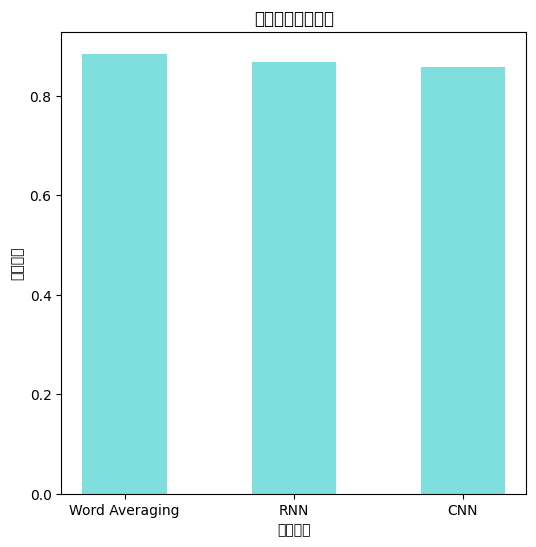

In [44]:
# 已知三个值绘制一个柱状图
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
plt.figure(figsize=(6,6))
x=np.arange(3)
y=[test_acc1,test_acc2,test_acc3]
plt.bar(x,y,width=0.5,align='center',color='c',alpha=0.5)
plt.xticks(x,['Word Averaging','RNN','CNN'])
plt.xlabel('模型类别')
plt.ylabel('测试精度')
plt.title('三种模型测试精度')
plt.show()

这里的图是因为不支持中文字体出现了方框

# 相关扩展实验


### 调试代码时候撰写的其他rnn和cnn代码

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
def train(model, iterator, optimizer, crit):
    epoch_loss, epoch_acc = 0., 0.
    total_len = 0.
    model.train()    
    for batch in iterator:
        # forward pass
        # print("batch.text.shape:",batch.text.shape)
        preds = model(batch.text).squeeze()
        # print("preds.shape:",preds.shape)
        # print("batch.label.shape:",batch.label.shape)
        loss = crit(preds,batch.label)
        acc = binary_accuracy(preds,batch.label)
        # backward pass
        optimizer.zero_grad() #梯度清零
        loss.backward() # 反向传播，计算梯度
        optimizer.step() #更新参数
        
        epoch_loss += loss.item() * len(batch.label)
        epoch_acc += acc.item() * len(batch.label)
        total_len += len(batch.label)
    return epoch_loss/total_len, epoch_acc/total_len
def evaluate(model, iterator, crit):
    epoch_loss, epoch_acc = 0., 0.
    total_len = 0.
    model.eval()    
    for batch in iterator:
        # forward pass
        preds = model(batch.text).squeeze()
        loss = crit(preds,batch.label)
        acc = binary_accuracy(preds,batch.label)
        
        epoch_loss += loss.item() * len(batch.label)
        epoch_acc += acc.item() * len(batch.label)
        total_len += len(batch.label)
    model.train() 
    return epoch_loss/total_len, epoch_acc/total_len
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        hidden = self.dropout(hidden)
        return self.fc(hidden)

# 定义模型参数
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 100
output_dim = 1
num_layers = 2
bidirectional = True

# 创建模型实例
model = RNN(input_dim, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional).to(device)

# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
# 开始训练
N_EPOCHS = 20
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

# 加载最佳模型并评估测试数据
model.load_state_dict(torch.load('model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch: 01
	Train Loss: 0.667 | Train Acc: 58.77%
	Valid Loss: 0.614 | Valid Acc: 67.49%
Epoch: 02
	Train Loss: 0.596 | Train Acc: 68.07%
	Valid Loss: 0.592 | Valid Acc: 68.68%
Epoch: 03
	Train Loss: 0.556 | Train Acc: 72.14%
	Valid Loss: 0.583 | Valid Acc: 69.45%
Epoch: 04
	Train Loss: 0.453 | Train Acc: 79.49%
	Valid Loss: 0.565 | Valid Acc: 72.99%
Epoch: 05
	Train Loss: 0.409 | Train Acc: 82.39%
	Valid Loss: 0.405 | Valid Acc: 82.29%
Epoch: 06
	Train Loss: 0.539 | Train Acc: 71.18%
	Valid Loss: 0.664 | Valid Acc: 57.92%
Epoch: 07
	Train Loss: 0.616 | Train Acc: 66.93%
	Valid Loss: 0.638 | Valid Acc: 66.77%
Epoch: 08
	Train Loss: 0.515 | Train Acc: 76.94%
	Valid Loss: 0.520 | Valid Acc: 72.41%
Epoch: 09
	Train Loss: 0.362 | Train Acc: 86.62%
	Valid Loss: 0.361 | Valid Acc: 85.60%
Epoch: 10
	Train Loss: 0.259 | Train Acc: 91.03%
	Valid Loss: 0.342 | Valid Acc: 86.47%
Epoch: 11
	Train Loss: 0.216 | Train Acc: 92.99%
	Valid Loss: 0.334 | Valid Acc: 86.52%
Epoch: 12
	Train Loss: 0.166 | T

In [49]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)  # 在第二个维度上添加一个维度，用于卷积操作
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        output = self.fc(cat)
        return output

# 定义模型参数
vocab_size = len(TEXT.vocab)
embedding_dim = 50
n_filters = 3
filter_sizes = [3, 4, 5]
output_dim = 1
dropout = 0.5

# 创建模型实例
model = TextCNN(vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout)

# 将模型移动到GPU（如果可用）
model = model.to(device)
# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

# 训练模型
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in iterator:
        optimizer.zero_grad()
        text = batch.text.to(device)
        labels = batch.label.to(device)
        predictions = model(text.T).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# 测试模型
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text = batch.text.to(device)
            labels = batch.label.to(device)
            predictions = model(text.T).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# 定义计算准确率的函数
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# 开始训练
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# 进行测试
model.load_state_dict(torch.load('tut1-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch: 01
	Train Loss: 0.715 | Train Acc: 51.79%
	 Val. Loss: 0.671 |  Val. Acc: 63.68%
Epoch: 02
	Train Loss: 0.675 | Train Acc: 56.67%
	 Val. Loss: 0.647 |  Val. Acc: 66.90%
Epoch: 03
	Train Loss: 0.655 | Train Acc: 59.65%
	 Val. Loss: 0.620 |  Val. Acc: 69.74%
Epoch: 04
	Train Loss: 0.630 | Train Acc: 63.89%
	 Val. Loss: 0.594 |  Val. Acc: 70.93%
Epoch: 05
	Train Loss: 0.607 | Train Acc: 66.90%
	 Val. Loss: 0.567 |  Val. Acc: 72.37%
Test Loss: 0.564 | Test Acc: 72.47%


上面是作业中写过的一些代码，也是rnn和cnn，因为效果不同，采取了上面的版本而没有采取这些。

## 实验总结
实验中我们利用三个模型进行了文本的情感分类实验，分别是WordAVGModel，RNNModel和CNNModel。
我们尽量保持在相同训练情况下对比不同模型的实验效果，我们可以看到：

但是上述对比并不公平，因为三个模型的参数量不同，所以我们可以对比不同模型的参数量，然后对比不同模型的测试集上的表现。
模型的结构业务相同很难进行横向对比，比如CNN模型中的卷积核的个数，卷积核的大小，RNN模型中的隐藏层的大小，LSTM的层数等等。只能大概的观看在相同训练轮数下的测试集上的表现。整体效果上CNN要优于其他两个模型，但是CNN的参数量也是最大的。训练起来十分吃力。WordAVGModel的参数量最少，训练起来也是最快的，。RNN模型的参数量介于两者之间，训练起来也比较快。而三个模型的具体效果，比较随机，在尝试作业的时候多次训练，三者之间的相对关系一直有所变化，故没有固定的规律。很多时候模型的精读取决于参数和模型训练中的一些小技巧。上述的精度对比图说明不了什么结论